In [1]:
import datetime

date_time = datetime.datetime.now()

In [2]:
import json
import firebase_admin
from firebase_admin import credentials
from firebase_admin import firestore
import re
import sys

cred = credentials.Certificate("permissions.txt")
firebase_admin.initialize_app(cred)

# Initialize Firestore database client
db = firestore.client()

# Specify the collection to retrieve documents from and the number of documents to retrieve
collection_ref = db.collection("Livestreams")

# Returns an adjusted string
def process_string(input_string):
    # Translation table to replace ":" with a space
    translation_table = str.maketrans({":": " "})

    # Create a set to store unique words
    unique_words = set()

    # Iterate over words in the input string
    for word in input_string.translate(translation_table).split():
        # Check if the word has at least one capitalized character
        if any(c.isupper() for c in word):
            # Add the word to the set of unique words
            unique_words.add(word)

    # Return the unique words as a string
    return " ".join(unique_words)

# Load Firebase Database credentials
def retreiveChatData(numberOfVods):

    n_docs_to_retrieve = numberOfVods  # Change this to the desired number of documents to retrieve

    # Iterate over the first n documents in the collection
    docs = collection_ref.limit(n_docs_to_retrieve).stream()

    # Basic lists to store data in
    streamIDList = []
    multipleStreamVODChatList = {}

    # Select a list of document ID's to reference
    for doc in docs:
        doc_id = doc.id
        streamIDList.append(doc_id)

    # Download the ChatLogs as dictionaries and load a variable.
    for ids in streamIDList:

        sub_collection_ref = db.collection("Livestreams").document(ids).collection('ChatLogs')
        chat_logs = sub_collection_ref.stream()

        totalChatLog = []

        for chat_log in chat_logs:
            totalChatLog = totalChatLog + chat_log.to_dict()["Chats"]

        # adjust messages to only have relevant data

        totalChatLog = [chats for chats in totalChatLog if process_string(chats["message"])]

        for chats in totalChatLog:
            chats["message"] = process_string(chats["message"])


        list_size = sys.getsizeof(totalChatLog)
        print(f"List size: {list_size} bytes")

        # Create a finalList of lists of message objects in
        multipleStreamVODChatList[ids] = totalChatLog


    print(multipleStreamVODChatList.keys()) # Print the dictionary Keys to confirm
    return multipleStreamVODChatList
    # From here on out, we can use the StreamVodChatList to examine multiple unique VOD chats, compare if needed.


# Load Firebase Database credentials
def retreiveSpecificChat(vodID):

    collection_ref = db.collection("Livestreams").document(vodID).collection('ChatLogs')
    chat_logs = collection_ref.stream()
    # Download the ChatLogs as dictionaries and load a variable.

    totalChatLog = []

    for chat_log in chat_logs:
        totalChatLog = totalChatLog + chat_log.to_dict()["Chats"]

    # adjust messages to only have relevant data

    totalChatLog = [chats for chats in totalChatLog if process_string(chats["message"])]

    for chats in totalChatLog:
        chats["message"] = process_string(chats["message"])

    return totalChatLog
    # From here on out, we can use the StreamVodChatList to examine multiple unique VOD chats, compare if needed.



In [3]:
vodIDStringMinimum = '1810011271' # The minimum needed for sufficient data to draw conclusions (15 chats per Min)
vodIDStringExpected = '1823236342' # The expected chat logs we'd most likely receive (24 chats per Min)
vodIdString_99Perc = '1816825048' # The Chat that would cover 99.99% of chats (86 chats per Min)

# Data is now set to idea parameters
data = {vodIDStringExpected: retreiveSpecificChat(vodIDStringExpected)}

# data = retreiveChatData(1)

In [4]:
import pandas as pd

In [5]:
keys = data.keys()
print("Keys:", keys)

Keys: dict_keys(['1823236342'])


In [6]:
data = pd.DataFrame(data)
data.to_csv("vog_data.csv")

In [7]:
import ast

# Read the CSV file
csv_data = pd.read_csv("vog_data.csv", skiprows=1, header=None, names=["data"])

# Convert the string representation of dictionaries to actual dictionaries
csv_data["data"] = csv_data["data"].apply(ast.literal_eval)

# Create a new DataFrame from the dictionaries
data = pd.DataFrame(list(csv_data["data"]))

#deleting username row (might need for other analyses)
data = data.drop('username', axis=1)

# Print the resulting DataFrame
print(data)

      timestamp                                 message
0        0.3167  Strippin Streaming I Just I'm Chatting
1        0.3667                              stripDance
2        0.5333                               coxHypers
3        0.6167                              stripDance
4        0.7000                                 Amazing
...         ...                                     ...
3441   302.8833                                 NODDERS
3442   302.9333                                       D
3443   302.9500                                Smadge I
3444   302.9833                                  Smadge
3445   303.0000                              Game BASED

[3446 rows x 2 columns]


In [8]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3446 entries, 0 to 3445
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  3446 non-null   float64
 1   message    3446 non-null   object 
dtypes: float64(1), object(1)
memory usage: 54.0+ KB


,timestamp,message
0,0.3167,Strippin Streaming I Just I'm Chatting
1,0.3667,stripDance
2,0.5333,coxHypers
3,0.6167,stripDance
4,0.7000,Amazing


In [9]:
# create dummy variables
dummy_vars = pd.get_dummies(data['message'])

# concatenate the dummy variables with the original dataframe
data_with_dummies = pd.concat([data, dummy_vars], axis=1)

# drop the original message column
data_with_dummies = data_with_dummies.drop('message', axis=1)

data_with_dummies = pd.DataFrame(data_with_dummies)

# preview the resulting dataframe
print(data_with_dummies.head())

   timestamp  "ALIENS" I  "I'm  "Layna 4Head DEAD"  "Must've  \
0     0.3167           0     0                   0         0   
1     0.3667           0     0                   0         0   
2     0.5333           0     0                   0         0   
3     0.6167           0     0                   0         0   
4     0.7000           0     0                   0         0   

   "SAAAAAAAAAAAAM" A  #NeverPreorder Remember  'B' Big  (But I  \
0                   0                        0        0       0   
1                   0                        0        0       0   
2                   0                        0        0       0   
3                   0                        0        0       0   
4                   0                        0        0       0   

   //clips.twitch.tv/CharmingSlipperySangCmonBruh-VrYcMWV8psPgjt-M  ...  \
0                                                  0                ...   
1                                                  0          

In [10]:
data_with_dummies = data_with_dummies.set_index('timestamp')

In [11]:
data_t = data_with_dummies.T

In [12]:
data_t.head()

timestamp,0.3167,0.3667,0.5333,0.6167,0.7000,0.7833,0.8167,0.8667,0.9500,1.2000,...,302.5667,302.6000,302.6167,302.6500,302.8167,302.8833,302.9333,302.9500,302.9833,303.0000
"""ALIENS"" I",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""I'm",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Layna 4Head DEAD""",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""Must've",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
"""SAAAAAAAAAAAAM"" A",0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [13]:
pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [14]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [15]:

# trying to strip stop-words
# def is_significant(word):
#     return word not in stop_words

# def main():
#     result = []

#     for _, row in data_t.iterrows():
#         word = str(row.iloc[0]).strip()

#         if is_significant(word):
#             new_line = '\t'.join(str(v) for v in row)
#             result.append(new_line)

#     output = '\n'.join(result)
#     print(output)

# if __name__ == '__main__':
#     main()




In [16]:
import numpy as np

n_messages = 1000

# Creating a copy of the first x rows of the DataFrame to avoid modifying the original one
data_t_copy = data_t.iloc[:n_messages].copy()

# Grouping by column names and using max() to maintain values
data_t_copy = data_t_copy.groupby(data_t_copy.columns, axis=1).max()

# Resetting the index to use a new column name for the first column
data_t_copy.reset_index(inplace=True)
data_t_copy.rename(columns={"index": "words"}, inplace=True)

# Converting the 'words' column to a string data type
data_t_copy['words'] = data_t_copy['words'].astype(str)

# Splitting the words in the 'words' column
words_split = data_t_copy['words'].str.split()

# Creating a new DataFrame with individual words in each row while maintaining the values in the columns
data_list = []
for index, row in data_t_copy.iterrows():
    for word in words_split[index]:
        new_row = row.copy()
        new_row['words'] = word
        data_list.append(new_row)

df_expanded = pd.DataFrame(data_list).reset_index(drop=True)

df_expanded = df_expanded.iloc[:n_messages].copy()

print(df_expanded.head())





timestamp     words  0.3167  0.3667  0.5333  0.6167  0.7  0.7833  0.8167  \
0          "ALIENS"       0       0       0       0    0       0       0   
1                 I       0       0       0       0    0       0       0   
2              "I'm       0       0       0       0    0       0       0   
3            "Layna       0       0       0       0    0       0       0   
4             4Head       0       0       0       0    0       0       0   

timestamp  0.8667  0.95  ...  302.5667  302.6  302.6167  302.65  302.8167  \
0               0     0  ...         0      0         0       0         0   
1               0     0  ...         0      0         0       0         0   
2               0     0  ...         0      0         0       0         0   
3               0     0  ...         0      0         0       0         0   
4               0     0  ...         0      0         0       0         0   

timestamp  302.8833  302.9333  302.95  302.9833  303.0  
0                 0    

In [17]:
import pandas as pd
import numpy as np

# Convert the first row to a list of floats, representing timestamps in minutes
timestamps = [float(x) for x in df_expanded.columns[2:]]

second_interval = 60

# Convert the timestamps from minutes to seconds
timestamps = [ts * 60 for ts in timestamps]


# Create a mapping of column names to their corresponding group (every 30 seconds)
group_mapping = {col: int(ts // second_interval) for col, ts in zip(df_expanded.columns[2:], timestamps)}

# Transpose the DataFrame (excluding the first row and 'words' column), so that columns become rows
data_transposed = df_expanded.drop(df_expanded.index[0]).drop('words', axis=1).T

# Group the transposed DataFrame by the group mapping and take the maximum value in each group
grouped_data = data_transposed.groupby(group_mapping).max()

# Transpose the grouped data back and reset the index
grouped_df = grouped_data.T

# Add the 'words' column back to the grouped DataFrame
grouped_df.insert(0, 'words', df_expanded['words'][1:])






In [18]:
print(grouped_df.head())
print(grouped_df.info())

timestamp   words  0.0  1.0  2.0  3.0  4.0  6.0  7.0  8.0  9.0  ...  294.0  \
1               I    0    0    0    0    0    0    0    0    0  ...      0   
2            "I'm    0    0    0    0    0    0    0    0    0  ...      0   
3          "Layna    0    0    0    0    0    0    0    0    0  ...      0   
4           4Head    0    0    0    0    0    0    0    0    0  ...      0   
5           DEAD"    0    0    0    0    0    0    0    0    0  ...      0   

timestamp  295.0  296.0  297.0  298.0  299.0  300.0  301.0  302.0  303.0  
1              0      0      0      0      0      0      0      0      0  
2              0      0      0      0      0      0      0      0      0  
3              0      0      0      0      0      0      0      0      0  
4              0      0      0      0      0      0      0      0      0  
5              0      0      0      0      0      0      0      0      0  

[5 rows x 295 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999 ent

In [20]:
# ###Rapidfuzz word matching
# !pip install rapidfuzz
# from rapidfuzz import fuzz, process

# import pandas as pd

# # Sample dataframe

# df = grouped_df

# fuzz_ratio = 95

# words = df['words'].unique()
# mapping = {}
# for word in words:
#     potential_matches = [m for m in mapping.keys() if fuzz.ratio(m, word) > fuzz_ratio]
#     if potential_matches:
#         mapping[word] = mapping[potential_matches[0]]
#     else:
#         mapping[word] = word

# df['words'] = df['words'].map(mapping)

# combined_df = df.groupby('words').max().reset_index()

# print(combined_df.head())
#print(combined_df.info())


In [21]:

# ###FUZZYWUZZY word matching
# #transforming similar words into a standard form, then combining rows with identical words
# !pip install fuzzywuzzy
# from fuzzywuzzy import fuzz
# from fuzzywuzzy import process

# # step 1: create mapping of words to standard form

# #fuzz ratio toggles the amount of similarity between words that combines them
# fuzz_ratio=95

# words = grouped_df['words'].unique()
# mapping = {}
# for word in words:
#     # find existing keys in mapping that are a close match to word
#     potential_matches = [m for m in mapping.keys() if fuzz.ratio(m, word) > fuzz_ratio]
#     if potential_matches:
#         # if there are close matches, map word to the first match
#         mapping[word] = mapping[potential_matches[0]]
#     else:
#         # if there are no close matches, map word to itself
#         mapping[word] = word

# # step 2: apply mapping to dataframe
# grouped_df['words'] = grouped_df['words'].map(mapping)

# # step 3: combine rows with the same standard form
# combined_df = grouped_df.groupby('words').max().reset_index()


# print(combined_df.head())
# print(combined_df.info())


In [25]:
### word matching analysis###
### use only for analysis of word matching.

from rapidfuzz import fuzz, process
import pandas as pd

# Sample dataframe

df = grouped_df

# Fuzz ratios to test
fuzz_ratios = range(70, 100)

# Initialize a dictionary to store mappings for each fuzz_ratio
mappings = {}

for fuzz_ratio in fuzz_ratios:
    words = df['words'].unique()
    mapping = {}
    for word in words:
        potential_matches = [m for m in mapping.keys() if fuzz.ratio(m, word) > fuzz_ratio]
        if potential_matches:
            mapping[word] = mapping[potential_matches[0]]
        else:
            mapping[word] = word
    mappings[fuzz_ratio] = mapping

# Write mappings to a text file
with open('fuzzy_mapping.txt', 'w') as f:
    for fuzz_ratio, mapping in mappings.items():
        f.write(f'Fuzz ratio: {fuzz_ratio}\n')
        for word, standard_form in mapping.items():
            if word != standard_form:
                f.write(f'  Word: {word} -> Standard form: {standard_form}\n')
        f.write('\n')


In [21]:
#!pip install tslearn

In [22]:
# #Clustering Method 1: Kmeans with dynamic time warping
# #prohibitively slow in current form
# import numpy as np
# from tslearn.clustering import TimeSeriesKMeans
# from tslearn.preprocessing import TimeSeriesScalerMeanVariance

# # Assuming df_expanded is the dataframe you want to cluster
# # Remove the first column (words) and transpose the remaining data for clustering
# data_to_cluster = df_expanded.iloc[:, 1:]

# # Scale the time series data
# scaler = TimeSeriesScalerMeanVariance()
# data_scaled = scaler.fit_transform(data_to_cluster)

# # Define the number of clusters
# n_clusters = 2

# # Perform k-means clustering using DTW distance
# kmeans_dtw = TimeSeriesKMeans(n_clusters=n_clusters, metric='dtw', random_state=42)
# labels = kmeans_dtw.fit_predict(data_scaled)

# # Print cluster labels for each time series
# print(labels)
# SET PARAMS FOR SCORING TRACKER
# algo = TimeSeriesKMeans
# dist = dtw

In [23]:
# print(labels)

In [24]:
# np.savetxt('labels.csv', labels, delimiter=',')

In [25]:
# #Clustering Method 2: Hierarchical with dynamic time warping

In [26]:
#record data size being clustered

data_size = combined_df.size

In [27]:
pip install dtaidistance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 25.6 MB/s eta 0:00:00


Computing distance matrix...
Distance matrix computed in:  120.09247875213623  seconds
Performing hierarchical clustering...
Clustering performed in:  0.009598731994628906  seconds


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


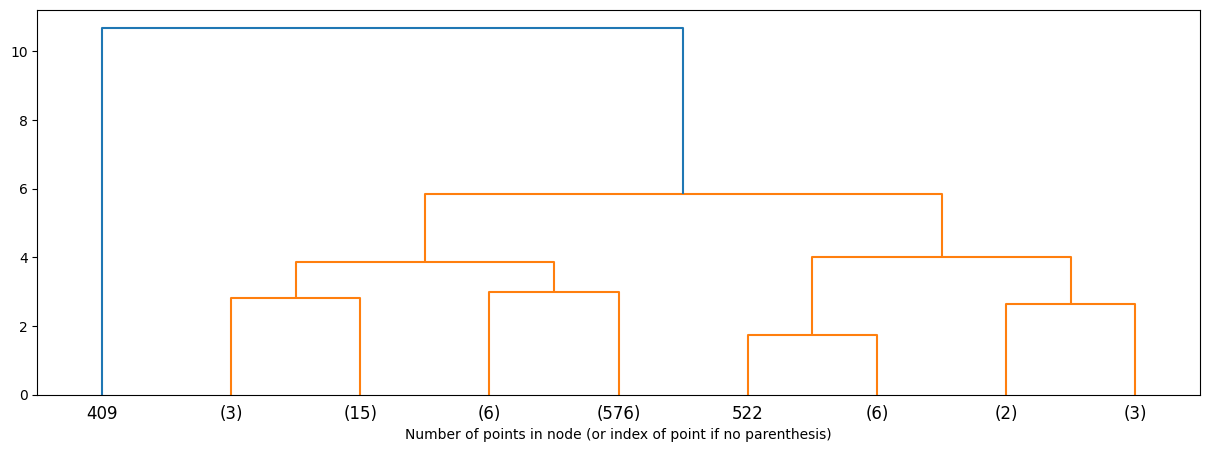

For the interval of  60 clustering time:  0.009598731994628906


In [28]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from dtaidistance import dtw
import matplotlib.pyplot as plt
import time
from tqdm import tqdm

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

df_expanded = combined_df
data = df_expanded.to_numpy()

# Remove the first column (text)
numeric_data = data[:, 1:].astype(np.float64)

# Compute the pairwise distance matrix using DTW
start = time.time()
print("Computing distance matrix...")
mp = True
distance_matrix = dtw.distance_matrix_fast(numeric_data, use_mp=mp)
end = time.time()
print("Distance matrix computed in: ", end - start, " seconds")
dist_time = end - start

# Perform hierarchical clustering using the distance matrix
start = time.time()
print("Performing hierarchical clustering...")
distance_threshold = 2
n_clusters = None
affinity = 'precomputed'
linkage='complete'
model = AgglomerativeClustering(distance_threshold=distance_threshold, n_clusters=n_clusters, affinity=affinity, linkage=linkage)
model = model.fit(distance_matrix)
end = time.time()
print("Clustering performed in: ", end - start, " seconds")
algo_time = end-start

# Plot the dendrogram
fig, ax = plt.subplots(figsize=(15, 5))
plot_dendrogram(model, truncate_mode='level', p=3, ax=ax)
plt.xlabel("Number of points in node (or index of point if no parenthesis)")
plt.show()

print("For the interval of ", second_interval, "clustering time: ", end - start)

# SET PARAMS FOR SCORING TRACKER
algo = "AgglomerativeClustering"
dist = "dtw"




In [29]:
labels = model.labels_

In [30]:
print(labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 5 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 0 0 0 0 2 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 2 6 0 2 0 0 0 2 0 0 0 0 0 0 5 1 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 3 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 5 0 0 0 0 0 0 6 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0
 0 0 7 0 0 4 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 5 2 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [31]:
np.savetxt("labels.csv", labels, delimiter=",")

In [32]:
from sklearn import metrics

#Silhouette Score: Measures how close each sample in one cluster is to the samples in the neighboring clusters. The best value is 1 and the worst value is -1.
#Values near 0 indicate overlapping clusters. Negative values generally indicate that a sample has been assigned to the wrong cluster, as a different cluster is more similar.
silhouette_score = metrics.silhouette_score(distance_matrix, labels, metric='precomputed')

#Calinski-Harabasz Index: Also known as the Variance Ratio Criterion, it is the ratio of the sum of between-clusters dispersion and of inter-cluster dispersion for all clusters.
#The score is higher when clusters are dense and well separated, which relates to a standard concept of a cluster.
calinski_harabasz_score = metrics.calinski_harabasz_score(numeric_data, labels)

#Davies-Bouldin Index: It is defined as the average similarity measure of each cluster with its most similar cluster, where similarity is the ratio of within-cluster distances to between-cluster distances.
#The minimum score is zero, with lower values indicating better clustering.
davies_bouldin_score = metrics.davies_bouldin_score(numeric_data, labels)

print('Silhouette Score (1 is best): ', silhouette_score)
print('Calinski Harabasz Score (higher is better): ', calinski_harabasz_score)
print('Davies Bouldin Score (lower is better): ', davies_bouldin_score)


Silhouette Score (1 is best):  0.6919516734083234
Calinski Harabasz Score (higher is better):  24.998080179793522
Davies Bouldin Score (lower is better):  2.7833608710826576


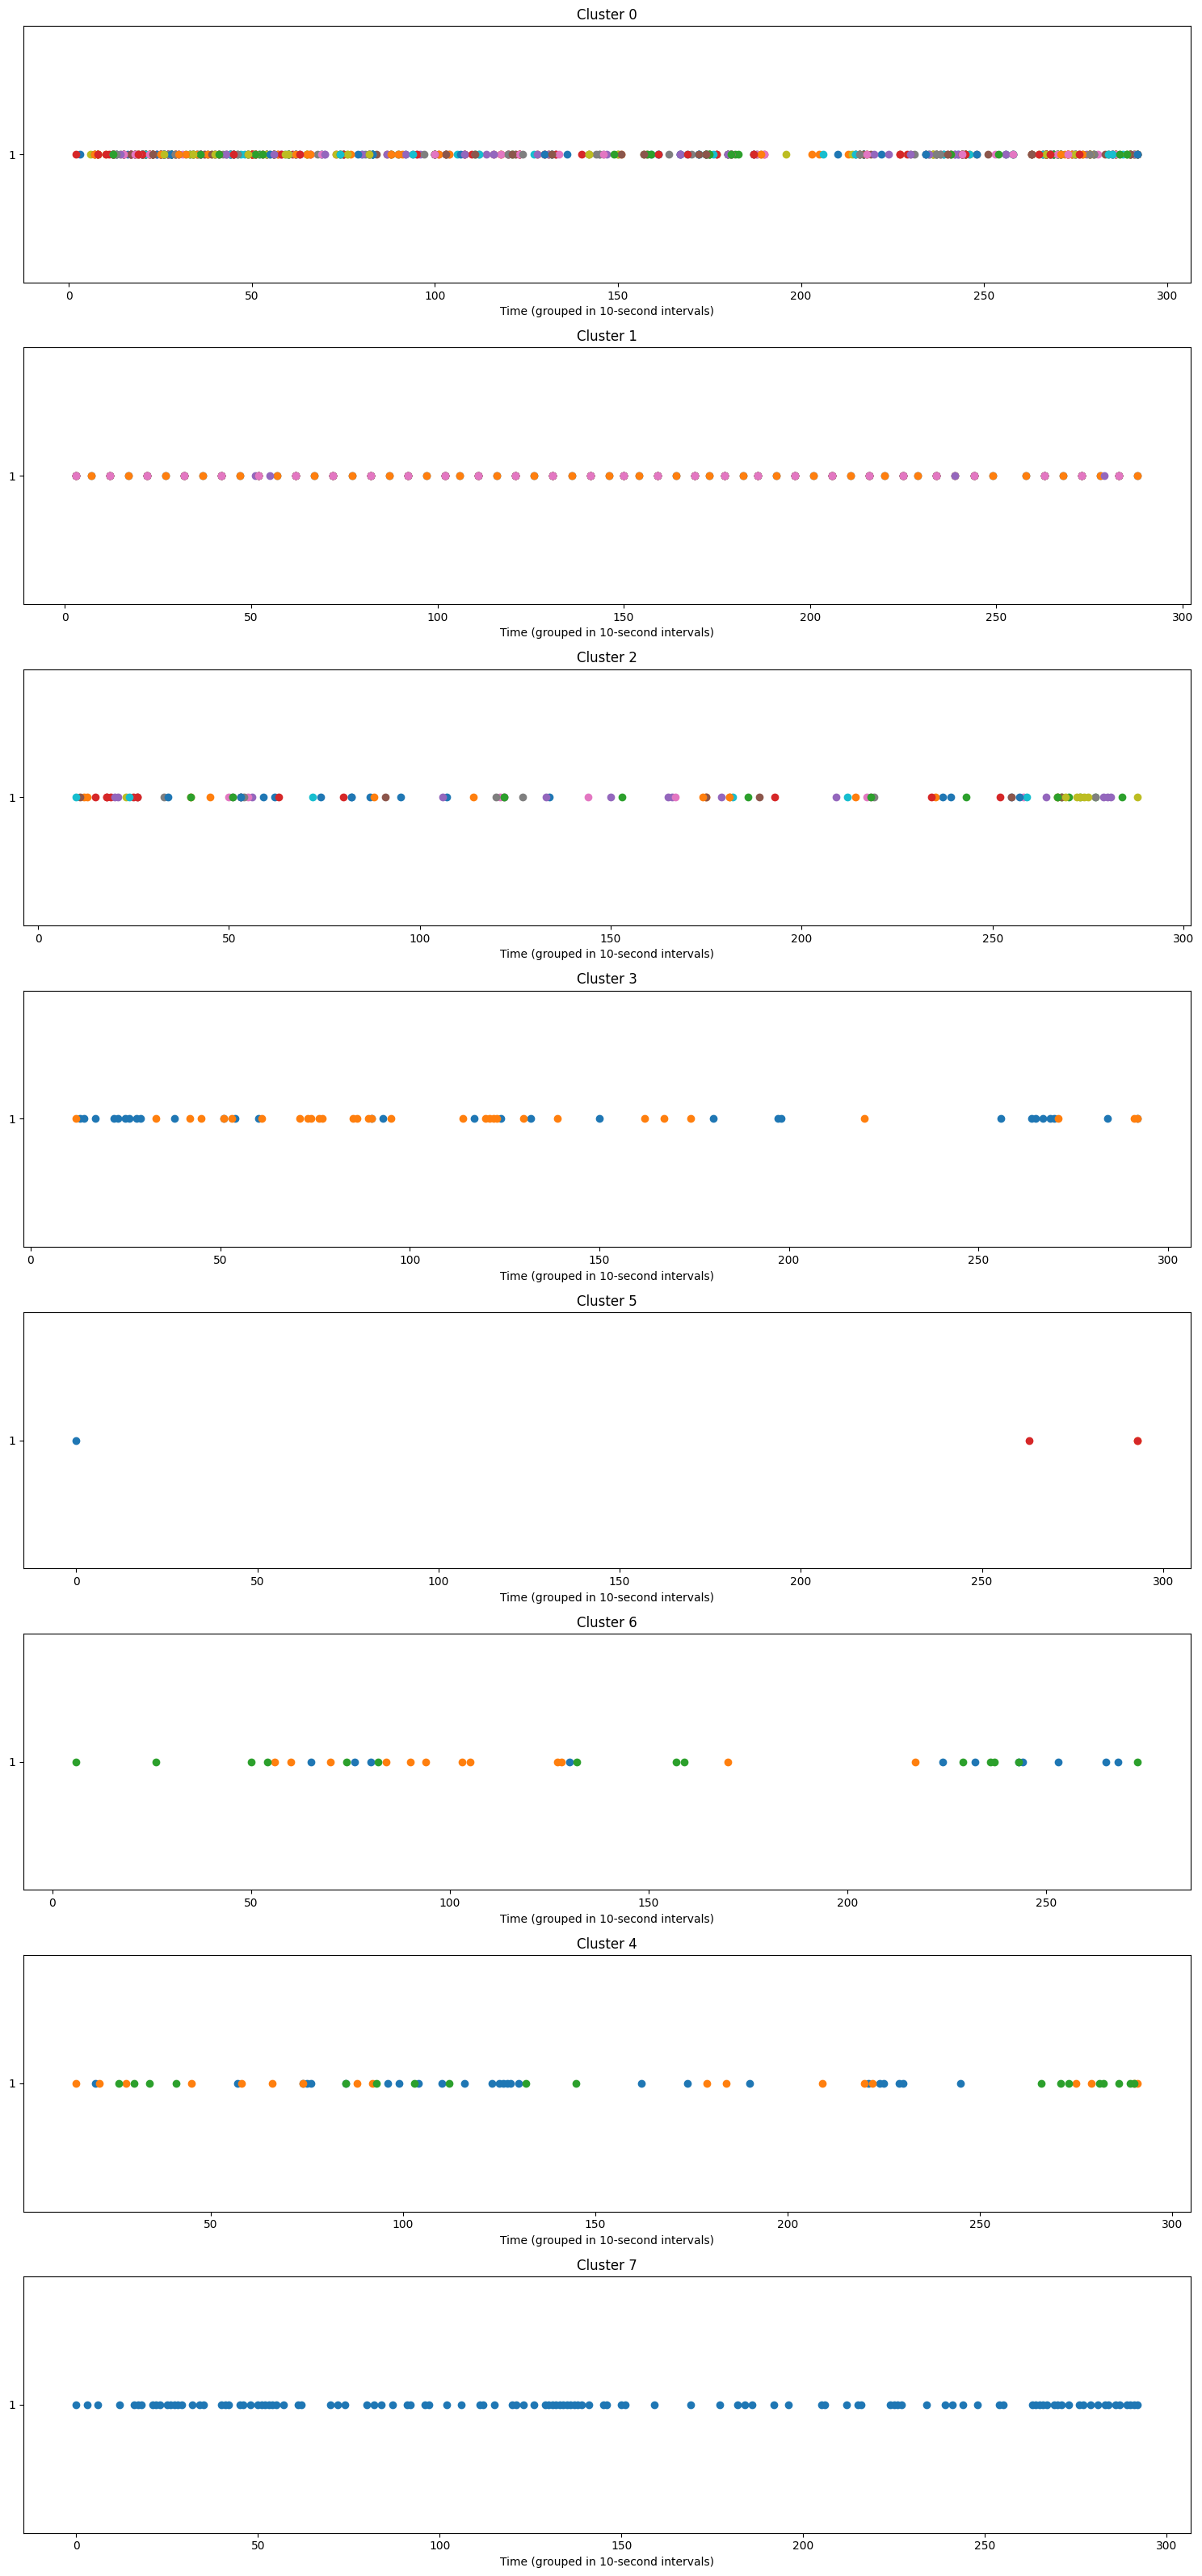

In [33]:
# Create a dictionary to store data of each cluster
clusters = {}
for i, label in enumerate(labels):
    if label not in clusters:
        clusters[label] = []
    clusters[label].append(numeric_data[i])

# Calculate the number of rows and columns for the grid of plots
n_labels = len(clusters)

# Set the size of the entire figure
plt.figure(figsize=(15, 4 * n_labels))

# Plot the data for each cluster in a grid
for idx, (label, data) in enumerate(clusters.items(), start=1):
    ax = plt.subplot(n_labels, 1, idx)
    for row in data:
        ones_indices = np.where(row == 1)
        ax.scatter(ones_indices, np.ones_like(ones_indices), marker='o')
    ax.set_title(f"Cluster {label}")
    ax.set_xlabel("Time (grouped in 10-second intervals)")
    ax.set_ylim(0, 2)
    ax.set_yticks([1])
    ax.set_yticklabels(['1'])

plt.tight_layout()
plt.show()




In [34]:
num_labels = n_labels

In [35]:

# # Create a dictionary to store data of each cluster
# clusters = {}
# for i, label in enumerate(labels):
#     if label not in clusters:
#         clusters[label] = []
#     clusters[label].append(numeric_data[i])

# # Set the size of the figure
# plt.figure(figsize=(15, 4))

# # Define the colors for each cluster
# colors = plt.cm.get_cmap('viridis', len(clusters))

# # Define the text for each cluster - hardcoded WILL NOT WORK WITH EACH INTERATION
# cluster_texts = {
#     0: ":_fusAD:, :_fusApril::_fusApril:, :_fusBlind:",
#     1: ":_fus7::_fus7::_fus7:, :_fus7:see, :_fusComfy::_fusComfy::_fus7:",
#     2: ":_fusPat:, AINTNOWAY, AYO",
#     3: ":skull:, :_fusD::_fusD::_fusD:, Ahhahaa",
#     4: ":rolling_on_the_floor_laughing::rolling_on_the_floor_laughing::rolling_on_the_floor_laughing::rolling_on_the_floor_laughing, AYOOO",
#     5: "Woooooo, Yesssss, wideVIBE, !@Green",
#     6: "AHAHAHAHA, BIGWOW, Broooo, Canâ€™t",
#     7: ":_fusKeK:, :rolling_on_the_floor_laughing:, ????",
#     8: "..., :_fusKeK:, :_fusOMEGA:"
# }

# # Plot the data for each cluster with a different color
# for idx, (label, data) in enumerate(clusters.items()):
#     for row in data:
#         ones_indices = np.where(row == 1)
#         plt.scatter(ones_indices, np.full_like(ones_indices, idx), marker='o', color=colors(idx), label=f"Cluster {label}: {cluster_texts[label]}" if idx == 0 else None)

# plt.xlabel("Time (grouped into intervals)")
# plt.ylim(-1, len(clusters))
# plt.yticks(range(len(clusters)), [f"Cluster {label}" for label in clusters.keys()])
# plt.tight_layout()

# # Add the legend at the bottom of the plot
# legend_elements = [plt.Line2D([0], [0], marker='o', color='w', label=f"Cluster {label}: {cluster_texts[label]}", markerfacecolor=colors(idx), markersize=8) for idx, label in enumerate(clusters.keys())]
# plt.legend(handles=legend_elements, bbox_to_anchor=(0.5, -0.25), loc='upper center', ncol=3)

# plt.show()





In [36]:
df_expanded.to_csv("messages.csv")

In [37]:
#add interation to score tracker

######################################
#REMEMBER TO ADD NOTES & TESTING PHASE
######################################

testing_phase = "rapid fuzz testing"
notes = "testing rapid fuzz"

import csv

# Open the file in append mode ('a')
with open('score_tracker.csv', 'a', newline='') as f:
    writer = csv.writer(f)
    writer.writerow([testing_phase, date_time, n_messages, second_interval,fuzz_ratio, data_size, algo, algo_time, dist, dist_time, mp, distance_threshold, n_clusters, affinity, linkage, num_labels, silhouette_score, calinski_harabasz_score, davies_bouldin_score, notes])


In [38]:
dtw.try_import_c(verbose=True)

All ok ...
== Packages ==
- Numpy version: 1.22.4
- Matplotlib version: 3.7.1
- Scipy version: 1.10.1
== System information ==
namespace(name='cpython', cache_tag='cpython-310', version=sys.version_info(major=3, minor=10, micro=11, releaselevel='final', serial=0), hexversion=50990064, _multiarch='x86_64-linux-gnu')
== Compilation information ==
Compiler type: unix
--noopenmp: 0
--forceopenmp: 0
--noxpreprocessor: 0
--forcellvm: 0
--forcegnugcc: 0
--forcestatic: 0
Cython found (during compilation)
- Version: 0.29.32
- Locations: <module 'Cython' from '/tmp/pip-build-env-l2jmr8ns/overlay/lib/python3.10/site-packages/Cython/__init__.py'>
Numpy found (during compilation):
- Version: 1.23.3
- Location: <module 'numpy' from '/tmp/pip-build-env-l2jmr8ns/overlay/lib/python3.10/site-packages/numpy/__init__.py'>
Checking if gcc redirects to clang
gcc --version # with stdout=-1, stderr=-1, input=, encoding=ascii

Using GNU GCC settings (gcc)
Checking for OpenMP availability for gcc
gcc -dM -E -Xp

True